<h1> Classification d'abeilles </h1>



## Chargement des données

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-03-22 17:19:05.130470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 17:19:06.179633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### test

In [2]:
# Paramètres
IMG_SIZE = 224 # pour utiliser ResNet

In [3]:
train_dir = "/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/train/"
val_dir = "/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/val/"

In [44]:
import os
import glob

def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    return img / 255.0 # normalize image

def process_path(file_path, label):
    img = get_image(file_path)
    return img, label

train_images = glob.glob(os.path.join(train_dir, "*/*"))
train_labels = [img.split("/")[-2] for img in train_images]
class_names = sorted(set(train_labels))
train_labels = [class_names.index(l) for l in train_labels]
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_image_count = len(train_ds)
train_ds = train_ds.shuffle(train_image_count, reshuffle_each_iteration=False)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
nb_classes = len(class_names)

print("Class Names: ", class_names)
print("Number of classes: ", nb_classes)
print("Number of train images: ", train_image_count)


val_images = glob.glob(os.path.join(val_dir, "*/*"))
val_labels = [img.split("/")[-2] for img in val_images]
val_labels = [class_names.index(l) for l in val_labels]
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_image_count = len(val_ds)
val_ds = val_ds.shuffle(val_image_count, reshuffle_each_iteration=False)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print("Number of val images: ", val_image_count)


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size=16)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
print("\nData loaded & Optimized for performance.")



Class Names:  ['Aglaoapis tridentata', 'Amegilla albigena', 'Amegilla garrula', 'Amegilla quadrifasciata', 'Andrena agilissima', 'Andrena albopunctata', 'Andrena apicata', 'Andrena barbilabris', 'Andrena bicolor', 'Andrena bicolorata', 'Andrena bimaculata', 'Andrena carantonica', 'Andrena chrysosceles', 'Andrena cineraria', 'Andrena clarkella', 'Andrena colletiformis', 'Andrena denticulata', 'Andrena dorsata', 'Andrena flavipes', 'Andrena florea', 'Andrena fulva', 'Andrena fuscipes', 'Andrena fuscosa', 'Andrena gravida', 'Andrena haemorrhoa', 'Andrena hattorfiana', 'Andrena helvola', 'Andrena humilis', 'Andrena labialis', 'Andrena labiata', 'Andrena lagopus', 'Andrena leucolippa', 'Andrena limbata', 'Andrena marginata', 'Andrena minutula', 'Andrena morio', 'Andrena nigriceps', 'Andrena nigroaenea', 'Andrena nitida', 'Andrena nycthemera', 'Andrena ovatula', 'Andrena pandellei', 'Andrena pilipes', 'Andrena praecox', 'Andrena propinqua', 'Andrena proxima', 'Andrena ranunculi', 'Andrena ro

2024-03-22 17:59:47.570065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


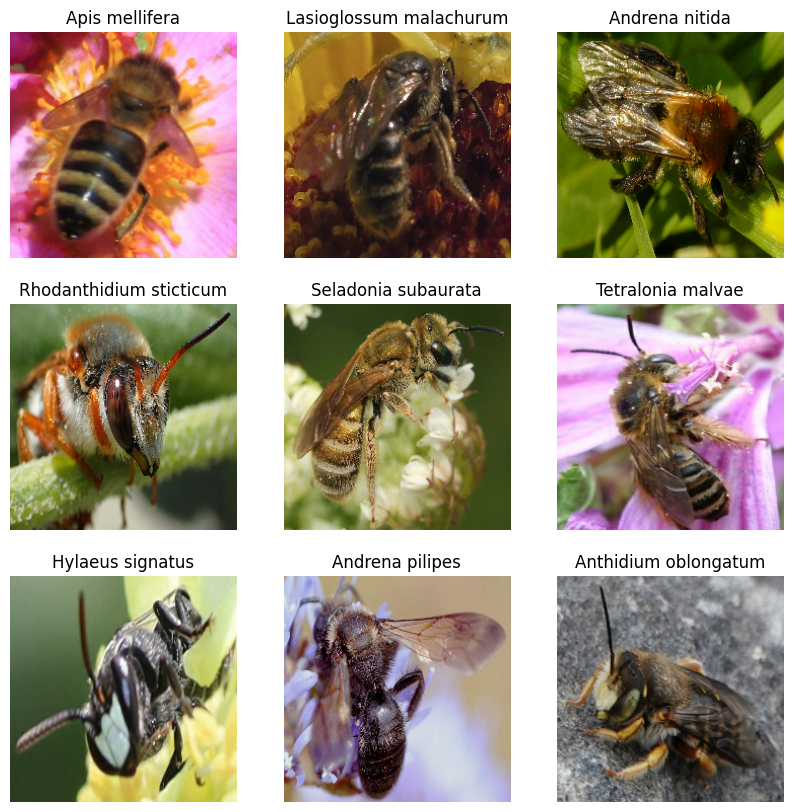

In [47]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("float32"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


In [35]:
import numpy as np

for image, label in train_ds.take(2):
    image = np.array(image)
    print("Image shape: ", image.shape)
    print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  224
Image shape:  (224, 224, 3)
Label:  73


2024-03-22 17:45:57.802321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### end of test

In [ ]:
# Paramètres
IMG_SIZE = 224 # pour utiliser ResNet

In [3]:
# Récupération des dataset pour l'entraînement (train, val)
# Shuffle à false pour avoir accès aux images depuis
# leur chemin d'accès avec train_ds.file_paths
train_ds = keras.utils.image_dataset_from_directory(
    directory='/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/train/',
    labels='inferred',
    label_mode='categorical',
    shuffle = False,
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/val/',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

class_names = train_ds.class_names
print(class_names)
nb_classes = len(class_names)
print(nb_classes)

Found 83363 files belonging to 306 classes.


2024-03-22 10:49:06.610883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9956 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-03-22 10:49:06.611799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10527 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:a1:00.0, compute capability: 6.1


Found 9403 files belonging to 306 classes.
['Aglaoapis tridentata', 'Amegilla albigena', 'Amegilla garrula', 'Amegilla quadrifasciata', 'Andrena agilissima', 'Andrena albopunctata', 'Andrena apicata', 'Andrena barbilabris', 'Andrena bicolor', 'Andrena bicolorata', 'Andrena bimaculata', 'Andrena carantonica', 'Andrena chrysosceles', 'Andrena cineraria', 'Andrena clarkella', 'Andrena colletiformis', 'Andrena denticulata', 'Andrena dorsata', 'Andrena flavipes', 'Andrena florea', 'Andrena fulva', 'Andrena fuscipes', 'Andrena fuscosa', 'Andrena gravida', 'Andrena haemorrhoa', 'Andrena hattorfiana', 'Andrena helvola', 'Andrena humilis', 'Andrena labialis', 'Andrena labiata', 'Andrena lagopus', 'Andrena leucolippa', 'Andrena limbata', 'Andrena marginata', 'Andrena minutula', 'Andrena morio', 'Andrena nigriceps', 'Andrena nigroaenea', 'Andrena nitida', 'Andrena nycthemera', 'Andrena ovatula', 'Andrena pandellei', 'Andrena pilipes', 'Andrena praecox', 'Andrena propinqua', 'Andrena proxima', 'An

## Augmentation de données : Sequence et Albumentations

In [4]:
from albumentations import (Compose, Rotate, HorizontalFlip, VerticalFlip, Affine, RandomBrightnessContrast, ChannelShuffle)
import albumentations as A

AUGMENTATIONS_TRAIN = Compose([
    Rotate(limit=[0,100], p=0.5),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Affine(shear=[-45, 45], p=0.5),
    RandomBrightnessContrast(p=0.5)
])

In [8]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2 as cv

class AbeillesSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_train, y_train, batch_size, augmentations):
        self.x_train = x_train
        self.y_train = y_train
        self.classes = class_names
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(len(x_train))
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(x_train.shape[0] / float(self.batch_size)))
    
    # Application de l'augmentation de données à chaque image du batch
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMG_SIZE, IMG_SIZE, 3))
        batch_y = by
        
        # Pour chaque image du batch
        for i in range(len(bx)):
            class_labels = []
            class_id = np.argmax(by[i])
            class_labels.append(self.classes[class_id])

            # Application de l'augmentation à l'image
            img = cv.imread(bx[i])
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            transformed = self.augment(image=img)
            batch_x[i] = transformed['image']
      
        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    # idx = position du batch (idx = 5 => on prend le 5ème batch)
    def __getitem__(self, idx):
        batch_x = self.x_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
           
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)

        # Normalisation des données
        batch_x = tf.keras.applications.resnet.preprocess_input(batch_x)
        
        return batch_x, batch_y

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

In [13]:
import numpy as np

print(len(train_ds),len(validation_ds))
x_train = np.array(train_ds.file_paths)
print(len(x_train))
print(len(train_ds.file_paths))
print(len(validation_ds.file_paths))

5211 588
83363
83363
9403


In [13]:
# Les images sont stockées avec les chemins d'accès
import numpy as np

x_train = np.array(train_ds.file_paths)
y_train = np.zeros((len(x_train), nb_classes))

ind_data = 0
for bx, by in train_ds.as_numpy_iterator():
  y_train[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

2024-03-21 16:56:13.756802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# Instanciation de la Sequence
train_ds_aug = AbeillesSequence(x_train, y_train, batch_size=16, augmentations=AUGMENTATIONS_TRAIN)

# Normalisation des données de validation
import numpy as np
import tensorflow as tf

x_val = np.zeros((len(validation_ds.file_paths), IMG_SIZE, IMG_SIZE, 3))
y_val = np.zeros((len(validation_ds.file_paths), nb_classes))

ind_data = 0
for bx, by in validation_ds.as_numpy_iterator():
  x_val[ind_data:ind_data+bx.shape[0]] = bx
  y_val[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

x_val = tf.keras.applications.resnet.preprocess_input(x_val)

2024-03-21 16:58:24.112244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Création du modèle

In [40]:
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import tensorflow as tf

### Poids d'imagenet

In [41]:
conv_base = keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=nb_classes,
)

model = keras.Sequential(
    [
        conv_base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')
    ]
)

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 71)                145479    
                                                                 
Total params: 42,803,655
Trainable params: 42,698,311
Non-trainable params: 105,344
_________________________________________________________________


### Poids INat2021

In [ ]:
from tensorflow import keras
conv_base = keras.models.load_model('drive/MyDrive/Stage2A/INat2021/2623871_resnet50_simclr_v1_inat20_no_top.h5')

model = keras.Sequential(
    [
        conv_base,
        layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')
    ]
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 71)                145479    
                                                                 
Total params: 42,803,655
Trainable params: 42,698,311
Non-trainable params: 105,344
_________________________________________________________________


## Hierarchical loss

In [1]:
import pandas as pd
import numpy as np

hierarchy_csv = "/home/eremy/Documents/CODE/bound_v1/dataset_analysis/306_hierarchy.csv"
hierarchy = pd.read_csv(hierarchy_csv)

specie = list(hierarchy["specie"].unique())
nb_specie = len(specie)

genus = list(hierarchy["genus"].unique())
nb_genus = len(genus)

family = list(hierarchy["family"].unique())
nb_family = len(family)

order = list(hierarchy["order"].unique())
nb_order = len(order)

class_ = list(hierarchy["class"].unique())
nb_class = len(class_)

species_to_genus = np.zeros((nb_genus, nb_specie))
genus_to_family = np.zeros((nb_family, nb_genus))
family_to_order = np.zeros((nb_order, nb_family))
order_to_class = np.zeros((nb_class, nb_order))

for i in range(nb_specie):
  # specie -> genus
  genus_species = hierarchy.at[i, "genus"]
  ind_genus = genus.index(genus_species)
  species_to_genus[ind_genus, i] = 1

  # genus -> family
  family_species = hierarchy.at[i, "family"]
  ind_family = family.index(family_species)
  genus_to_family[ind_family, ind_genus] = 1

  # family -> order
  order_species = hierarchy.at[i, "order"]
  ind_order = order.index(order_species)
  family_to_order[ind_order, ind_family] = 1

  # order -> class
  class_species = hierarchy.at[i, "class"]
  ind_class = class_.index(class_species)
  order_to_class[ind_class, ind_order] = 1

In [ ]:
from numpy.ma.core import transpose
from keras import backend as K
import math
import tensorflow as tf

# Définition de la fonction de perte
def Hierarchicaloss(specie_to_genus, genus_to_family, family_to_order, batch_size, alpha=0.1):

    def weight(height=1):
      return math.exp(-alpha * height)
    
    def specie_loss(y_true, y_pred):
      height = 0
      return weight(height) * K.categorical_crossentropy(y_true, y_pred)
  
    def specie_to_genus_loss(y_true, y_pred):
      height = 1
      y_true_genus = K.transpose(tf.raw_ops.MatMul(a=specie_to_genus, b=tf.cast(y_true, tf.float64), transpose_b=True))
      y_pred_genus = K.transpose(tf.raw_ops.MatMul(a=specie_to_genus, b=tf.cast(y_pred, tf.float64), transpose_b=True))
      return weight(height) * K.categorical_crossentropy(y_true_genus, y_pred_genus), y_true_genus, y_pred_genus
    
    def genus_to_family_loss(y_true, y_pred):
      height = 2
      y_true_family = K.transpose(tf.raw_ops.MatMul(a=genus_to_family, b=y_true, transpose_b=True))
      y_pred_family = K.transpose(tf.raw_ops.MatMul(a=genus_to_family, b=y_pred, transpose_b=True))
      return weight(height) * K.categorical_crossentropy(y_true_family, y_pred_family), y_true_family, y_pred_family
    
    def family_to_order_loss(y_true, y_pred):
      height = 3
      y_true_order = K.transpose(tf.raw_ops.MatMul(a=family_to_order, b=y_true, transpose_b=True))
      y_pred_order = K.transpose(tf.raw_ops.MatMul(a=family_to_order, b=y_pred, transpose_b=True))
      return weight(height) * K.categorical_crossentropy(y_true_order, y_pred_order)#, y_true_order, y_pred_order

    def HIERARCHICAL_loss(y_true, y_pred):
      loss_specie = tf.cast(specie_loss(y_true, y_pred), tf.float64)
      loss_genus, y_true_genus, y_pred_genus = specie_to_genus_loss(y_true, y_pred)
      loss_family, y_true_family, y_pred_family = genus_to_family_loss(y_true_genus, y_pred_genus)
      # loss_order, y_true_order, y_pred_order = family_to_order_loss(y_true_family, y_pred_family)
      loss_order = family_to_order_loss(y_true_family, y_pred_family)
      return (loss_specie + loss_genus + loss_family + loss_order)/batch_size
   
    # Return a function
    return HIERARCHICAL_loss

In [3]:
loss=[Hierarchicaloss(species_to_genus, genus_to_family, family_to_order, batch_size=16, alpha=0.5)]

## Entraînement du modèle

In [46]:
# Ajout de l'optimiseur, de la fonction coût et des métriques
lr = 1e-3
model.compile(optimizers.SGD(learning_rate=lr, momentum=0.9), loss=loss, metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [47]:
# Les callbacks
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/MyDrive/Stage2A/cap500/ResNet101/ResNet101_HierarchicalLossScheduler/Poids/best_model_scheduler',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

#early_stopping_cb = tf.keras.callbacks.EarlyStopping(
#    monitor="val_categorical_accuracy",
#    min_delta=0.01,
#    patience=8,
#    verbose=1,
#    mode="auto")
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=5, min_lr=0.00001, verbose=1)

In [48]:
history = model.fit(train_ds_aug, epochs=150, validation_data = (x_val, y_val), callbacks=[model_checkpoint_cb, reduce_lr_cb])

Epoch 1/150
  6/933 [..............................] - ETA: 4:17:26 - loss: 0.4709 - categorical_accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: ignored